<a href="https://colab.research.google.com/github/sharadnatarajSJSU/SVD_recommendation/blob/main/Model_Based_Recommendation_system_Simple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from math import sqrt
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

In [ ]:
ratings = pd.read_csv('/content/drive/MyDrive/SJSU assignment Docs/255/Project files/ml-latest-small/ratings.csv', sep=',', encoding='latin-1', usecols=['userId','movieId','rating','timestamp'])


In [ ]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [ ]:
movies = pd.read_csv('/content/drive/MyDrive/SJSU assignment Docs/255/Project files/ml-latest-small/movies.csv', sep=',', encoding='latin-1', usecols=['movieId','title','genres'])

In [ ]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
users = pd.read_csv('/content/drive/MyDrive/SJSU assignment Docs/255/Project files/ml-100k/ml-100k/u.user', sep='|', encoding='latin-1',header=None,names=['user_id','Age','gender','Occupation','zipcode'])

In [ ]:
users.head()

,user_id,Age,gender,Occupation,zipcode
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


#Most popular movies

<BarContainer object of 19 artists>

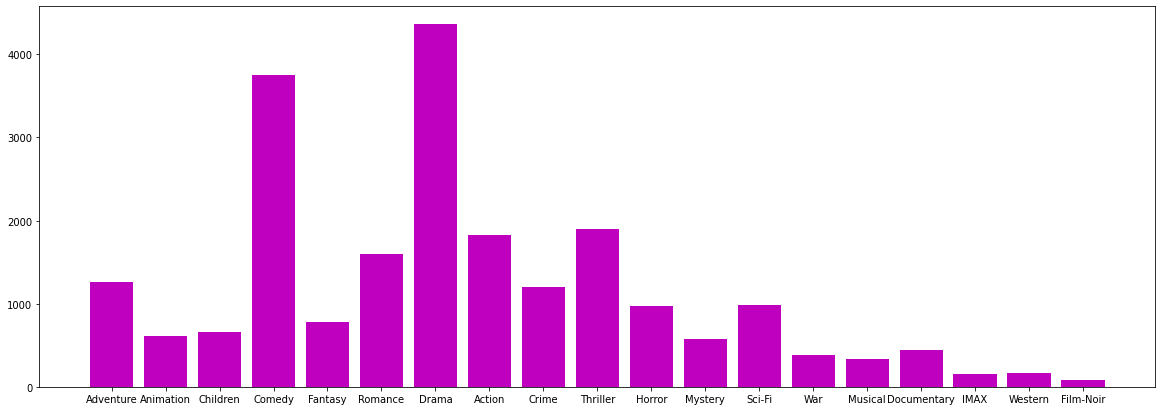

In [ ]:
plt.figure(figsize=(20,7))
generlist = movies['genres'].apply(lambda generlist_movie : str(generlist_movie).split("|"))
geners_count = {}

for generlist_movie in generlist:
    for gener in generlist_movie:
        if(geners_count.get(gener,False)):
            geners_count[gener]=geners_count[gener]+1
        else:
            geners_count[gener] = 1       
geners_count.pop("(no genres listed)")
plt.bar(geners_count.keys(),geners_count.values(),color='m')

We will be using colaborative filtering. Where the Users are also compared along with movies. We will have a list where if user A has seen the movie x and y, user B has seen X then the system will recommend movie y to user B

Model Based colaborative filtering

In [ ]:
n_users = ratings.userId.unique().shape[0]
n_movies = ratings.movieId.unique().shape[0]

In [ ]:
n_users

610

In [ ]:
n_movies

9724

In [ ]:
Ratings = ratings.pivot(index = 'userId', columns ='movieId', values = 'rating').fillna(0)
Ratings.head()

movieId,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,34,36,38,39,40,41,42,43,...,185135,185435,185473,185585,186587,187031,187541,187593,187595,187717,188189,188301,188675,188751,188797,188833,189043,189111,189333,189381,189547,189713,190183,190207,190209,190213,190215,190219,190221,191005,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
R = np.array(Ratings)
#print(R)
user_ratings_mean = np.mean(R, axis = 1)
#print(user_ratings_mean.shape)
print(user_ratings_mean.size)
Ratings_demeaned = R - user_ratings_mean.reshape(-1, 1) ## Making the user_ratings_mean vertical by reshaping

610


In [ ]:
sparsity = round(1.0 - len(ratings) / float(n_users * n_movies), 3)

In [ ]:
sparsity

0.983

#using SVD for matrix factorization to explore latent features of our data like unrated movies etc..


In [ ]:
from scipy.sparse.linalg import svds 

In [ ]:
U, sigma, Vt = svds(Ratings_demeaned, k = 50)

In [ ]:
sigma = np.diag(sigma)

In [ ]:
print('Shape of sigma: ', sigma.shape)
print(sigma)

Shape of sigma:  (50, 50)
[[ 67.86628347   0.           0.         ...   0.           0.
    0.        ]
 [  0.          68.1967072    0.         ...   0.           0.
    0.        ]
 [  0.           0.          69.02678246 ...   0.           0.
    0.        ]
 ...
 [  0.           0.           0.         ... 184.86187801   0.
    0.        ]
 [  0.           0.           0.         ...   0.         231.22453421
    0.        ]
 [  0.           0.           0.         ...   0.           0.
  474.20606204]]


In [ ]:
print('Shape of U: ', U.shape)
print('Shape of Vt: ', Vt.shape)

Shape of U:  (610, 50)
Shape of Vt:  (50, 9724)


In [ ]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)

In [ ]:
preds = pd.DataFrame(all_user_predicted_ratings, columns = Ratings.columns)
preds.head()

movieId,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,34,36,38,39,40,41,42,43,...,185135,185435,185473,185585,186587,187031,187541,187593,187595,187717,188189,188301,188675,188751,188797,188833,189043,189111,189333,189381,189547,189713,190183,190207,190209,190213,190215,190219,190221,191005,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
0,2.167328,0.402751,0.840184,-0.076281,-0.551337,2.504091,-0.890114,-0.026443,0.196974,1.593259,-0.474160,0.237581,0.346021,0.053504,-0.108999,1.355739,-0.426912,-0.077438,0.284485,0.417117,0.245054,0.362827,-0.139144,0.255003,0.067873,-0.220421,-0.033781,0.076522,-0.159481,-0.072023,-0.318595,0.774845,1.631756,-0.336022,0.139459,0.739682,-0.014906,0.084650,0.541279,0.134242,...,-0.178088,0.082812,0.039631,0.069620,0.039631,0.033760,0.016202,0.151717,0.036710,-0.172538,-0.155189,-0.121909,0.070459,0.038139,0.052525,0.090319,0.010978,0.012984,-0.018321,0.050599,-0.008879,-0.085795,-0.013370,0.006966,0.016995,0.004960,0.006966,0.004960,0.004960,-0.030425,-0.023453,-0.019967,-0.026939,-0.026939,-0.023453,-0.026939,-0.023453,-0.023453,-0.023453,-0.058732
1,0.211459,0.006658,0.033455,0.017419,0.183430,-0.062473,0.083037,0.024158,0.049330,-0.152530,0.077881,0.064805,0.005182,-0.001014,0.045648,0.096822,-0.027822,-0.004426,0.108646,-0.008286,-0.077978,0.016521,0.009482,0.023615,-0.212386,0.040676,-0.001671,-0.021906,-0.174248,0.013497,0.031743,-0.202221,-0.163632,0.030075,0.000392,-0.033238,0.000224,0.017713,0.009105,0.033852,...,0.107281,-0.026524,0.027091,0.011932,0.027091,0.016864,0.051425,0.069516,0.057564,-0.006654,-0.005944,0.014142,-0.002021,0.038409,0.035970,-0.002728,0.002845,0.003324,0.019168,-0.001314,-0.001049,-0.003101,0.009848,0.001888,0.004281,0.001410,0.001888,0.001410,0.001410,0.024940,0.019498,0.016777,0.022219,0.022219,0.019498,0.022219,0.019498,0.019498,0.019498,0.032281
2,0.003588,0.030518,0.046393,0.008176,-0.006247,0.107328,-0.012416,0.003779,0.007297,-0.059362,-0.005484,0.031175,0.019045,-0.008570,0.009015,0.029135,-0.021266,0.017135,-0.058321,-0.012562,-0.076699,0.011520,-0.014717,0.041779,-0.040655,-0.004429,-0.009282,-0.009510,0.071715,0.010940,0.023559,0.023674,-0.001701,0.006543,0.006831,0.067326,0.007865,-0.001794,0.011360,0.001821,...,0.010848,-0.005258,0.012808,0.017701,0.012808,0.012132,0.009292,0.002576,0.012102,-0.001268,-0.000341,0.020286,0.014689,0.004859,0.014408,0.016599,0.008085,0.008100,0.003702,0.012780,0.007564,0.003369,0.005910,0.008053,0.008131,0.008038,0.008053,0.008038,0.008038,0.005310,0.005909,0.006209,0.005610,0.005610,0.005909,0.005610,0.005909,0.005909,0.005909,0.008004
3,2.051549,-0.387104,-0.252199,0.087562,0.130465,0.270210,0.477835,0.040313,0.025858,-0.017365,0.637032,-0.092990,0.280611,0.268450,-0.027183,0.161275,1.801845,-0.258694,-0.035952,0.131731,1.912042,-0.169062,-0.034940,0.063111,1.661501,0.158679,0.026145,0.551609,0.492758,0.256954,-0.220697,2.094105,1.940568,0.880095,-0.077526,1.327586,0.003094,0.087768,0.102798,0.069933,...,-0.288689,0.111226,0.004181,0.059797,0.004181,0.006699,-0.011445,0.190691,-0.072316,0.121225,0.109122,-0.003448,-0.019439,0.049429,0.005512,-0.025047,-0.002677,-0.003250,0.010189,-0.013831,0.002714,0.060707,-0.022289,-0.001531,-0.004396,-0.000958,-0.001531,-0.000958,-0.000958,0.006164,0.004836,0.004172,0.005500,0.005500,0.004836,0.005500,0.004836,0.004836,0.004836,-0.023311
4,1.344738,0.778511,0.065749,0.111744,0.273144,0.584426,0.254930,0.128788,-0.085541,1.023455,0.974908,-0.070313,0.135688,0.237220,0.208138,0.552464,0.771266,-0.049298,0.326467,0.082279,1.158006,0.332666,0.156395,0.109681,0.861100,0.242800,0.033883,0.124262,0.044031,-0.000574,0.465793,1.254308,1.893785,0.999793,-0.017239,1.256341,-0.011412,0.111539,-0.012218,0.110956,...,-0.007826,0.023460,-0.006995,-0.012447,-0.006995,-0.004094,-0.009139,0.025778,0.004529,-0.017096,-0.015755,-0.002459,-0.006417,-0.003125,-0.008097,-0.007197,0.003527,0.004970,-0.009438,-0.005636,-0.003344,-0.010391,-

In [ ]:
def recommend_movies(predictions, userID, movies, original_ratings, num_recommendations):
    """
    Implementation of SVD by hand
    :param predictions : The SVD reconstructed matrix, 
    userID : UserId for which you want to predict the top rated movies, 
    movies : Matrix with movie data, original_ratings : Original Rating matrix, 
    num_recommendations : num of recos to be returned
    :return: num_recommendations top movies
    """ 
    # Get and sort the user's predictions
    user_row_number = userID - 1 # User ID starts at 1, not 0
    sorted_user_predictions = predictions.iloc[user_row_number].sort_values(ascending=False) # User ID starts at 1
    
    # Get the user's data and merge in the movie information.
    user_data = original_ratings[original_ratings.userId == (userID)]
    user_full = (user_data.merge(movies, how = 'left', left_on = 'movieId', right_on = 'movieId').
                     sort_values(['rating'], ascending=False)
                 )

    print('User {0} has already rated {1} movies.'.format(userID, user_full.shape[0]))
    print('Recommending highest {0} predicted ratings movies not already rated.'.format(num_recommendations))
    
    # Recommend the highest predicted rating movies that the user hasn't seen yet.
    recommendations = (movies[~movies['movieId'].isin(user_full['movieId'])].
         merge(pd.DataFrame(sorted_user_predictions).reset_index(), how = 'left',
               left_on = 'movieId',
               right_on = 'movieId').
         rename(columns = {user_row_number: 'Predictions'}).
         sort_values('Predictions', ascending = False).
                       iloc[:num_recommendations, :-1]
                      )

    return user_full, recommendations

In [ ]:
already_rated, predictions = recommend_movies(preds, 100, movies, ratings, 20)

User 100 has already rated 148 movies.
Recommending highest 20 predicted ratings movies not already rated.


In [ ]:
already_rated.head(20)

,userId,movieId,rating,timestamp,title,genres
86,100,1958,5.0,1100186258,Terms of Endearment (1983),Comedy|Drama
101,100,2423,5.0,1100186118,Christmas Vacation (National Lampoon's Christm...,Comedy
137,100,5620,5.0,1100186982,Sweet Home Alabama (2002),Comedy|Romance
55,100,1101,5.0,1100184137,Top Gun (1986),Action|Romance
125,100,4041,5.0,1100184235,"Officer and a Gentleman, An (1982)",Drama|Romance
70,100,1307,4.5,1100183745,When Harry Met Sally... (1989),Comedy|Romance
84,100,1912,4.5,1100186251,Out of Sight (1998),Comedy|Crime|Drama|Romance|Thriller
82,100,1777,4.5,1100184536,"Wedding Singer, The (1998)",Comedy|Romance
81,100,1680,4.5,1100184264,Sliding Doors (1998),Drama|Romance
80,100,1678,4.5,1100186254,"Joy Luck Club, The (1993)",Drama|Romance


In [ ]:
predictions

,movieId,title,genres
1202,1704,Good Will Hunting (1997),Drama|Romance
895,1259,Stand by Me (1986),Adventure|Drama
409,500,Mrs. Doubtfire (1993),Comedy|Drama
358,440,Dave (1993),Comedy|Romance
1185,1682,"Truman Show, The (1998)",Comedy|Drama|Sci-Fi
29,39,Clueless (1995),Comedy|Romance
1991,2797,Big (1988),Comedy|Drama|Fantasy|Romance
112,150,Apollo 13 (1995),Adventure|Drama|IMAX
2082,2918,Ferris Bueller's Day Off (1986),Comedy
1209,1721,Titanic (1997),Drama|Romance
